<H1>From Financial Compliance to Fraud Detection with Conditional Variational Autoencoders (CVAE) and Tensorflow</H1>
<BR>By Manuel Amunategui & Priya Dwivedi 

Just like <a href='https://arxiv.org/abs/1504.08083' target='blank'>Fast R-CNN</a> and <a href='https://arxiv.org/abs/1703.06870' target='blank'>Mask-R CNN</a> evolved from Convolutional Neural Networks (CNN), Conditional Variational Autoencoders (CVAE) and Variational Autoencoders (VAE) evolved from the classic autoencoder. CVAEs are the latest incarnation of unsupervised neural network anomaly detection tools offering some new and interesting abilities over plain autoencoders. 

<H2>Anomaly Detection on Financial Data</H2>

In this article, we're going to see how a CVAE can learn and generate the behavior of a particular stock's price action and use that as a model to detect unusual behavior. A CVAE can generate millions of data points and whenever real price action veers too far away from the bounds of these generated patterns we know that something different is happening.

<H2>The Autoencoder Can Reconstruct Data</H2>

We’ll start with the root model, the autoencoder is an unsupervised neural network that combines a data encoder and decoder. The encoder will take data and learn to reduce it in an efficient manner into a lower-dimensional space, known as the latent space representation. 

The decoder will take this reduced representation and blow it back up to its original size. This comes in handy around file reduction for efficient storage and transportation while still retaining the original (or good-enough) data information.

This is also used in anomaly detection. You train a model, feed new data into the encoder, compress it, then observe how well it rebuilds it. If the reconstruction error is abnormally high, that means the model struggled to rebuild the data and you may have an anomaly on your hands. 

![Image of Latent Space Representation](https://cdn-images-1.medium.com/max/1600/1*op0VO_QK4vMtCnXtmigDhA.png)


(source: <a href='https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df' target='blank'>Latent space visualization — Deep Learning bits 2)</a>

<H2>The variational autoencoder (VAE) Can Generate Data</H2>

The variational autoencoder (VAE) adds the ability to generate new synthetic data from this compressed representation. It is still an unsupervised model which describes the distribution of observed and latent variables from which it can learn to generate new data (versus only offering a reconstruction like the classic AE does). It does so by learning the probability distribution of the data and we can thus generate new data by using different latent variables used as input.


<H2>The Conditional Variational Autoencoders (CVAE) Can Generate Data by Label</H2>

With the CVAE, we can ask the model to recreate data (synthetic data) for a particular label. In the example of stock market data, we can ask it to recreate data for a particular stock symbol. When the model is trained, we pass the label to both the encoder and decoder, not to become a supervised model, but to add the ability to ask the decoder to generate new data down to the granularity of labels.


Code based on the following two great resources:
http://nnormandin.com/science/2017/07/01/cvae.html
http://ijdykeman.github.io/ml/2016/12/21/cvae.html

In [11]:
# install libraries for keras
# !pip3 install keras
# !pip3 install h5py

import pandas as pd  
import matplotlib.pyplot as plt
import datetime, random
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate as concat
from keras import backend as K
from keras.optimizers import Adam
%matplotlib inline

<H2>Part 1: Preparing the data</H2>

**Load stock market data from Kaggle/GitHub**

https://github.com/CNuge/kaggle-code/tree/master/stock_data

In [12]:
# Load locally
stock_data_file = 'data/sandp500/all_stocks_5yr.csv'
# Load directly from GitHub
stock_data_file = 'https://raw.githubusercontent.com/CNuge/kaggle-code/master/stock_data/all_stocks_5yr.csv'
stocks_df = pd.read_csv(stock_data_file, parse_dates=['date'])
stocks_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [13]:
# how many stocks
print('Stocks found:', len(set(stocks_df['Name'])))
print('Date range:', str(np.min(stocks_df['date']))[:10], '-', str(np.max(stocks_df['date']))[:10])

Stocks found: 505
Date range: 2013-02-08 - 2018-02-07


**Create a couple of quantitative features**

In [14]:
# create a couple of quantitative features 
stocks_df['day'] = stocks_df['date'].dt.weekday
stocks_df['day_of_month'] = stocks_df['date'].dt.day
stocks_df.head()

,date,open,high,low,close,volume,Name,day,day_of_month
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,4,8
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0,11
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,1,12
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2,13
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,3,14


**Simplify by only using DOW 30 stocks instead of full S&P 500**

In [16]:
stock_symbols = list(set(stocks_df['Name']))

dow_30_list = ['NKE', 'AXP', 'BA', 'C', 'CAT', 'DD', 'DIS', 'GE', 'CSCO', 'HD', 'CVX', 'V', 'IBM',
'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'GS', 'MRK', 'MSFT', 'PFE', 'PG', 'AAPL', 'UTX', 'VZ',
'WMT', 'XOM', 'TRV']
 
dow_30_symbols = (list(set(dow_30_list) & set(stock_symbols)))


In [17]:
# apply some more quantitative features but make sure it doesn't spill from 
# one stock to another
market_data = {}
for symbol in dow_30_symbols:
    # segregate data for that stock so it doesn't spill into other one
    temp_df = stocks_df[stocks_df['Name'] == symbol]
    open = temp_df['open']
    high = temp_df['high']
    low = temp_df['low']
    close = temp_df['close']
    volume = temp_df['volume']
    close_avg_3 =  pd.rolling_mean(temp_df['close'], 3)
    close_avg_5 =  pd.rolling_mean(temp_df['close'], 5)
    close_avg_10 =  pd.rolling_mean(temp_df['close'], 10)
    open_close = temp_df['close'] - temp_df['open']
    day_ = temp_df['day']
    day_of_month = temp_df['day_of_month']
    date = temp_df['date']
    # day of month
    
    market_data[symbol] = [open, high, low, close,
                                volume, close_avg_3, close_avg_5, close_avg_10, open_close, day_,
                               day_of_month, date]
                               

In [181]:
# rebuild data frame
fin_open = []
fin_high = []
fin_low = []
fin_close = []
fin_volume = []
fin_close_avg_3 = []
fin_close_avg_5 = []
fin_close_avg_10 = []
fin_open_close = []

fin_day_ = []
fin_day_of_month = []
fin_date = []
fin_symbol = []

fin_high_high_diff3 = []
fin_low_low_diff3 = []
fin_open_open_diff3 = []
fin_close_close_diff3 = []
fin_volume_volume_diff3 = []


for key, value in market_data.items():
    fin_open.extend(list(value[0]))
    fin_high.extend(list(value[1]))
    fin_low.extend(list(value[2]))
    fin_close.extend(list(value[3]))
    fin_volume.extend(list(value[4]))
    fin_close_avg_3.extend(list(value[5]))
    fin_close_avg_5.extend(list(value[6]))
    fin_close_avg_10.extend(list(value[7]))
    fin_open_close.extend(list(value[8]))
    fin_day_.extend(list(value[9]))
    fin_day_of_month.extend(list(value[10]))
    fin_date.extend(list(value[11]))
    fin_symbol.extend([key] * len(value[11]))

# build final data frame for CVAE
norm_stocks_df = pd.DataFrame({'symbol':fin_symbol, 
                            'open':fin_open,
                            'high':fin_high,
                            'low':fin_low,
                            'close':fin_close,
                            'raw_close':fin_close,
                            'volume':fin_volume,
                            'raw_volume':fin_volume,
                            'close_avg_3':fin_close_avg_3,
                            'close_avg_5':fin_close_avg_5,
                            'close_avg_10':fin_close_avg_10,
                            'open_close':fin_open_close,
                            'raw_open_close':fin_open_close,
                            'day':fin_day_,
                            'day_of_month':fin_day_of_month,
                            'date':fin_date})

# remove any rows with NaN or inf columns
norm_stocks_df = norm_stocks_df.replace([np.inf, -np.inf], np.nan)
norm_stocks_df = norm_stocks_df.dropna(how='any')

norm_stocks_df.head(5)

,close,close_avg_10,close_avg_3,close_avg_5,date,day,day_of_month,high,low,open,open_close,raw_close,raw_open_close,raw_volume,symbol,volume
9,38.52,37.804,37.986667,37.810,2013-02-22,4,22,38.52,37.710,37.76,0.76,38.52,0.76,20102745,KO,20102745
10,37.72,37.699,37.983333,37.870,2013-02-25,0,25,38.72,37.720,38.56,-0.84,37.72,-0.84,15879793,KO,15879793
11,38.11,37.649,38.116667,37.958,2013-02-26,1,26,38.19,37.775,37.95,0.16,38.11,0.16,15769957,KO,15769957
12,38.45,37.738,38.093333,38.102,2013-02-27,2,27,38.54,37.920,38.03,0.42,38.45,0.42,14277317,KO,14277317
13,38.72,37.889,38.426667,38.304,2013-02-28,3,28,38.97,38.420,38.47,0.25,38.72,0.25,19010564,KO,19010564


**Normalize And Impute Missing Data**

In [218]:
features = [f for f in list(norm_stocks_df) if f not in ['date', 'symbol', 'raw_close', 'raw_open_close', 'raw_volume']]

df = norm_stocks_df.copy()

# Take all numerical cols and normalize data b/w 0 and 1
df[features] = df[features].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

print(features)

df['symbol'].value_counts()

['close', 'close_avg_10', 'close_avg_3', 'close_avg_5', 'day', 'day_of_month', 'high', 'low', 'open', 'open_close', 'volume']


TRV     1250
CVX     1250
PG      1250
MRK     1250
DIS     1250
KO      1250
CSCO    1250
UTX     1250
HD      1250
NKE     1250
JNJ     1250
WMT     1250
AAPL    1250
INTC    1250
GS      1250
CAT     1250
VZ      1250
AXP     1250
JPM     1250
MSFT    1250
MMM     1250
GE      1250
C       1250
PFE     1250
V       1250
XOM     1250
MCD     1250
IBM     1250
BA      1250
Name: symbol, dtype: int64


**The CVAE is conditioned on the labels and the labels must be one hot encoded**

In [183]:

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

label = df['symbol']

le= LabelEncoder().fit(label)
encoded_Y = le.transform(label)  # convert categorical labels to integers
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

print(dummy_y[:4])

num_symbols = max(encoded_Y)
print(num_symbols)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
28


In [184]:
le.classes_

array(['AAPL', 'AXP', 'BA', 'C', 'CAT', 'CSCO', 'CVX', 'DIS', 'GE', 'GS',
       'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK',
       'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'V', 'VZ', 'WMT', 'XOM'],
      dtype=object)

**Split the dataset into train, validation and test sets**

Save a copy of the full data for a particular stock to investigate (in this case symbol 0, or AAPL)

In [240]:
###################################################
## save the stock of interest for anomaly testing
stock_symbol_identifier = 0
print('Generate stock data for:', 
      le.classes_[stock_symbol_identifier])
###################################################

df_stock = df[df['symbol']==le.classes_[stock_symbol_identifier]].tail(100)
stock_dummy = dummy_y[1150:1250]
stock_dummy.fill(0)
stock_dummy[:,stock_symbol_identifier] = 1

 
## Break into train and test dataset
features = [f for f in list(norm_stocks_df)]
X_train, X_test, y_train, y_test = train_test_split(df[features], dummy_y, test_size=0.20, random_state=26)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=89)

# take copy of test set with symbol and date features for anomaly investigation
X_test_with_symbol = X_test.copy()
features = [f for f in list(norm_stocks_df) if f not in ['date', 'symbol',  'raw_close', 'raw_open_close', 'raw_volume']]
X_test = X_test[features]
X_train = X_train[features]
X_valid = X_valid[features]

print("X shape: ", X_train.shape, X_valid.shape, X_test.shape)
print("Y shape: ", y_train.shape, y_valid.shape, y_test.shape)

Generate stock data for: AAPL
X shape:  (26100, 11) (2900, 11) (7250, 11)
Y shape:  (26100, 29) (2900, 29) (7250, 29)


In [241]:
features

['close',
 'close_avg_10',
 'close_avg_3',
 'close_avg_5',
 'day',
 'day_of_month',
 'high',
 'low',
 'open',
 'open_close',
 'volume']

In [242]:
X_train.tail()

,close,close_avg_10,close_avg_3,close_avg_5,day,day_of_month,high,low,open,open_close,volume
1954,0.225945,0.237173,0.228924,0.234242,0.50,0.333333,0.226425,0.228708,0.227291,0.362824,0.009354
7205,0.215390,0.219025,0.216370,0.218444,0.25,0.633333,0.212675,0.217799,0.213145,0.399712,0.054506
35230,0.211180,0.211297,0.212142,0.213852,0.00,0.233333,0.207477,0.213125,0.207938,0.410086,0.017189
36308,0.147911,0.151045,0.148307,0.150013,0.75,0.633333,0.145647,0.149498,0.146494,0.398559,0.035593
6455,0.182148,0.192645,0.184817,0.188841,1.00,0.866667,0.180318,0.183974,0.182047,0.381844,0.010108


In [243]:
## discard incomplete batches
m = 50 # batch size

num_batches_train = X_train.shape[0]//m
print(num_batches_train)
X_train_trun = X_train.head(num_batches_train*m)
y_train_trun = y_train[:num_batches_train*m,:]
print(X_train_trun.shape, y_train_trun.shape)

num_batches_valid = X_valid.shape[0]//m
X_valid_trun = X_valid.head(num_batches_valid*m)
y_valid_trun = y_valid[:num_batches_valid*m,:]
print(X_valid_trun.shape, y_valid_trun.shape)

num_batches_test = X_test.shape[0]//m
X_test_trun = X_test.head(num_batches_test*m)
y_test_trun = y_test[:num_batches_test*m,:]
print(X_test_trun.shape, y_test_trun.shape)

522
(26100, 11) (26100, 29)
(2900, 11) (2900, 29)
(7250, 11) (7250, 29)


<H2>Part 2: Build a Conditional Variational AutoEncoder</H2>

In [189]:
## Define Hyperparmeters

m = 50 # batch size
n_z = 2 # latent space size
encoder_dim = 5 # dim of encoder hidden layer
decoder_dim = 5 # dim of decoder hidden layer
decoder_out_dim = X_train.shape[1] # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


Note on Hyperparameters: We found that n_z =2 was sufficient for the problem and a 2d space was easy to visualize. The encoder_dim/decoder_dim should be relative to the total num of columns in the data. Around half of total num of columns is a good thumb rule

**The encoder**


In [190]:
## Explicitely define shape for the encoder
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

## Concatenate the input and the label for the CVAE
inputs = concat([X, label])

Once we've defined our inputs and merged them within the context of the graph, we'll pass them to a dense layer consisting of the previuosly specified number of neurons (5) and activation function (ReLU). That layer is then connected to layers that produce our mean ( μ ) and standard deviation ( log(σ) ) for the variational sampling that occurs later.



In [191]:
encoder_h = Dense(encoder_dim, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)
## Define the latent space - z layer
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

**The Latent Space**

First, using our sample_z function, we generate a vector of length n_z (in this case 2). In CVAE, we concatenate our latent z respresentation with the same sparse y vector that we initially merged to our pixel representation X in the input layers.


In [192]:

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])
# merge latent space with label
zc = concat([z, label])

**The Decoder**

Use the decoder to reconstruct back the input columns from the concatenated latent space


In [193]:

decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

**Defining loss**

In CVAEs, our loss is the sum of reconstruction error and the kullback-leibler divergence between our  μ  and log- σ  and the standard normal.


In [194]:

## Model will be trained on vae loss

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# instantiate a the keras model class API
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

**Training**

In [195]:

## Compile function
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

# compile and fit
n_epoch = 70
cvae_hist = cvae.fit([X_train_trun, y_train_trun], X_train_trun, verbose = 1, batch_size=m, epochs=n_epoch,
        validation_data = ([X_valid_trun, y_valid_trun], X_valid_trun),
        callbacks = [EarlyStopping(patience = 5)]).history



Train on 26100 samples, validate on 2900 samples
Epoch 1/70
26100/26100 [==============================] - 2s 73us/step - loss: 6.4459 - KL_loss: 0.0596 - recon_loss: 6.3863 - val_loss: 5.6873 - val_KL_loss: 0.0060 - val_recon_loss: 5.6813
Epoch 2/70
26100/26100 [==============================] - 1s 46us/step - loss: 5.5512 - KL_loss: 0.0026 - recon_loss: 5.5486 - val_loss: 5.5176 - val_KL_loss: 0.0010 - val_recon_loss: 5.5165
Epoch 3/70
26100/26100 [==============================] - 1s 49us/step - loss: 5.4707 - KL_loss: 7.0160e-04 - recon_loss: 5.4700 - val_loss: 5.4793 - val_KL_loss: 4.8184e-04 - val_recon_loss: 5.4788
Epoch 4/70
26100/26100 [==============================] - 1s 49us/step - loss: 5.4476 - KL_loss: 4.1604e-04 - recon_loss: 5.4471 - val_loss: 5.4655 - val_KL_loss: 3.2803e-04 - val_recon_loss: 5.4651
Epoch 5/70
26100/26100 [==============================] - 1s 46us/step - loss: 5.4388 - KL_loss: 2.8953e-04 - recon_loss: 5.4385 - val_loss: 5.4598 - val_KL_loss: 2.2866e-

**Evaluate model loss**

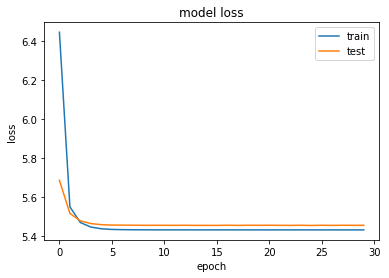

In [196]:

# ## Plot loss
# # Check plots - Loss
plt.plot(cvae_hist['loss'])
plt.plot(cvae_hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

<H2>Part 3: Exploring the model</H2>

In [197]:
def construct_numvec(identifier, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, identifier + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)


In [198]:
## Since the training set is huge, we extract a random subset for calculating anamoly threhsold
X_exp, X_rem, y_exp, y_rem = train_test_split(X_train_trun, y_train_trun, test_size=0.20, random_state=19)

In [199]:
## Predict z-space for the subset of training data
z_dataset = encoder.predict([X_rem, y_rem])

In [200]:
print(z_dataset.shape)

(5220, 2)


In [201]:
# Append z1, z2 columns of the X_rem dataframe
X_rem['z1'] = z_dataset[:,0]
X_rem['z2'] = z_dataset[:,1]
X_rem.head()
# actual range of the 2 dimensions of z
print(np.max(X_rem['z1']))
print(np.min(X_rem['z1']))
print(np.max(X_rem['z2']))
print(np.min(X_rem['z2']))

0.021988504
-0.009678107
0.020529924
-0.009065045


In [202]:
### Define reconstruction error for training set as 
###the mean squared difference between actual column value and predicted column value

def recon_error_cal(actual,predictions):
    recon_error = np.mean(np.power(actual - predictions, 2))
    recon_array = np.power(actual - predictions, 2)
    max_col = np.argmax(recon_array)
    return recon_error, max_col

In [203]:
 
# Calculate reconstruction error for every row in X_rem (subset of training set)
recon_on_train = [] 
max_contributor =[]
for i in range(X_rem.shape[0]): # for each row:
    z1 = X_rem.iloc[i]['z1']
    z2 = X_rem.iloc[i]['z2']
    z_ = [z1,z2]  # Define z vector
    identifier = int(np.argmax(y_rem[i]))
    vec = construct_numvec(identifier, z_) # concatenate z and label before passing to the decoder
    # uses identifier and z value 
    test_pred = decoder.predict(vec)
    transpose = test_pred.T
    transpose = np.squeeze(transpose) ## decoder predictions
    actuals = X_rem.iloc[i][features]

    recon_error, max_col = recon_error_cal(actuals, transpose)  ## reconstuction error b/w actuals and predicted
    ## Add this error to recon list
    recon_on_train.append(recon_error)
    max_contributor.append(max_col[0])

In [204]:
len(max_contributor)

5220

In [205]:
test_pred

array([[0.2677485 , 0.27602476, 0.27034447, 0.27574316, 0.5152265 ,
        0.49572846, 0.26660252, 0.27085325, 0.26723576, 0.39587855,
        0.00330581]], dtype=float32)

In [206]:
recon_train_se = pd.Series(recon_on_train)
print("90th percentile recon error", np.percentile(recon_train_se, 90))
print("95th percentile recon error", np.percentile(recon_train_se, 95))
anomaly_threshold =  np.percentile(recon_train_se, 95)
print('Selected anomaly threshold: ', anomaly_threshold)

90th percentile recon error 0.03803468042126875
95th percentile recon error 0.04304960233075609
Selected anomaly threshold:  0.04304960233075609


<H2>Part 4: Analyze performance of CVAE on test data</H2>

i) Calculate anomaly percent on test set

In [207]:
## Use encoder to predict the z-space for the test dataset
z_test = encoder.predict([X_test, y_test]) 
print(z_test.shape)

(7250, 2)


In [208]:
## Loop through every row of test dataset and calculate reconstruction error 

recon_on_test = []
max_contributor_test =[]

for i in range(z_test.shape[0]): # for each row:
    z_ = z_test[i]  # Define z vector
    identifier = int(np.argmax(y_test[i]))

    vec = construct_numvec(identifier, z_) # concatenate z and label before passing to the decoder
    test_pred = decoder.predict(vec)
    transpose = test_pred.T
    transpose = np.squeeze(transpose) #Decode predictions
    actuals = X_test.iloc[i]

    recon_error , max_col = recon_error_cal(actuals, transpose) # Error calculations 
    ## Add this error to recon list
    recon_on_test.append(recon_error)
    max_contributor_test.append(max_col)
    

recon_test_se = pd.Series(recon_on_test)
recon_test_se.shape

max_col_test = pd.Series(max_contributor_test)
max_col_test.shape

(7250,)

In [209]:
## Calculate Anomaly percent of the test dataset
anomaly_count = 0
for i in range(len(recon_test_se)):
    if recon_test_se[i] > anomaly_threshold:
        anomaly_count +=1
print(anomaly_count/X_test.shape[0])


0.05972413793103448


In [210]:
# investigate what is being flagged as anomalous 
X_test_with_symbol['recon_error'] = recon_on_test


In [211]:
# get all rows with recon_error larger than anomaly_threshold
errs = X_test_with_symbol[X_test_with_symbol['recon_error'] > anomaly_threshold]
errs.sort_values('recon_error', ascending=False)

,close,close_avg_10,close_avg_3,close_avg_5,date,day,day_of_month,high,low,open,open_close,raw_close,raw_open_close,raw_volume,symbol,volume,recon_error
25175,1.000000,0.993666,0.988963,0.996576,2018-02-01,0.75,0.000000,1.000000,1.000000,0.978159,0.512392,356.940,3.99,6067581,BA,0.009325,0.252103
25174,0.992486,0.988558,0.973078,0.988253,2018-01-31,0.50,1.000000,0.998613,0.998755,1.000000,0.220749,354.370,-6.13,11409626,BA,0.017970,0.248339
25172,0.952870,0.986759,0.967412,0.975133,2018-01-29,0.00,0.933333,0.950969,0.964604,0.944255,0.385591,340.820,-0.41,3324878,BA,0.004886,0.242020
25178,0.953133,0.995912,0.959085,0.994740,2018-02-06,0.25,0.166667,0.942851,0.898052,0.882840,1.000000,340.910,20.91,11935140,BA,0.018820,0.238643
25168,0.937579,0.968854,0.951813,0.978178,2018-01-23,0.25,0.733333,0.934963,0.948922,0.935894,0.318156,335.590,-2.75,4537784,BA,0.006849,0.204209
25158,0.863199,0.861393,0.857547,0.862517,2018-01-08,0.00,0.233333,0.853833,0.862775,0.850035,0.440346,310.150,1.49,4124862,BA,0.006181,0.162404
25154,0.824284,0.853132,0.830389,0.843729,2018-01-02,0.25,0.033333,0.813759,0.832081,0.812688,0.428818,296.840,1.09,2978918,BA,0.004327,0.141869
25148,0.818992,0.842320,0.832438,0.844439,2017-12-21,0.75,0.666667,0.817790,0.828329,0.819313,0.310663,295.030,-3.01,5398275,BA,0.008242,0.125636
25147,0.827384,0.838344,0.833532,0.843747,2017-12-20,0.50,0.633333,0.820519,0.837162,0.821743,0.369164,297.900,-0.98,2533689,BA,0.003606,0.119992
25111,0.714382,0.744660,0.718917,0.735584,2017-10-30,0.00,0.966667,0.708070,0.713307,0.696106,0.506916,259.250,3.80,3025919,BA,0.004403,0.109153


<H2>Part 5: Generate data for a stock and analyze anomalies</H2>
<BR>
Now for the fun part, let's generate data for our chosen stock of AAPL held using the dataframe we prepared earlier called "df_stock".

In [224]:
X_test.head()

,close,close_avg_10,close_avg_3,close_avg_5,day,day_of_month,high,low,open,open_close,volume
34596,0.199485,0.207492,0.200317,0.203592,0.75,0.033333,0.196296,0.201109,0.196627,0.407493,0.014375
12982,0.029471,0.027356,0.028784,0.028321,1.00,0.933333,0.027881,0.029793,0.029160,0.400000,0.028590
9424,0.302283,0.306384,0.304270,0.306410,0.50,0.466667,0.299211,0.305754,0.298600,0.404899,0.007347
15397,0.064570,0.064681,0.065068,0.065037,0.75,0.066667,0.064286,0.065811,0.064973,0.389193,0.012865
2554,0.246587,0.253459,0.249441,0.252795,0.50,0.066667,0.246049,0.250052,0.247020,0.369741,0.006714


In [225]:
df_stock[features].head()

,close,close_avg_10,close_avg_3,close_avg_5,day,day_of_month,high,low,open,open_close,volume
3786,0.144699,0.152967,0.144676,0.148409,1.00,0.700000,0.142077,0.145525,0.142787,0.403830,0.133151
3787,0.141353,0.151567,0.143824,0.146917,0.00,0.800000,0.143530,0.143818,0.144688,0.351916,0.149845
3788,0.143930,0.150221,0.144234,0.145969,0.25,0.833333,0.142052,0.141739,0.140543,0.418608,0.201950
3789,0.142093,0.149207,0.143355,0.145601,0.50,0.866667,0.142424,0.143005,0.142448,0.381513,0.236870
3790,0.140769,0.148093,0.143158,0.145201,0.75,0.900000,0.140537,0.143323,0.140638,0.386496,0.129831


In [258]:

## Use encoder to predict the z-space for the test dataset
features = [f for f in list(df_stock) if f not in ['date', 'symbol', 'raw_close', 'raw_volume', 'raw_open_close', 'recon_error']]
z_stock = encoder.predict([df_stock[features], stock_dummy]) 
print(z_stock.shape)

## Loop through each row of our single-stock dataset and calculate the reconstruction error 
recon_on_generated_stock = []
max_contributor_stock =[]

for i in range(z_stock.shape[0]):  
    z_ = z_stock[i]   
    identifier = int(np.argmax(stock_dummy[i]))

    vec = construct_numvec(identifier, z_) 
    test_pred = decoder.predict(vec)
    transpose = test_pred.T
    transpose = np.squeeze(transpose) 
    actuals = df_stock[features].iloc[i]

    recon_error , max_col = recon_error_cal(actuals, transpose) 
    ## Add this error to recon list
    recon_on_generated_stock.append(recon_error)
    max_contributor_stock.append(max_col)
    

recon_se = pd.Series(recon_on_generated_stock)
recon_se.shape

anomaly_threshold =  np.percentile(recon_se, 90)
print('anomaly_threshold:', anomaly_threshold)

max_col_test = pd.Series(max_contributor_stock)
max_col_test.shape



(100, 2)
anomaly_threshold: 0.083699166755841


(100,)

In [259]:
df_stock['recon_error'] = recon_on_generated_stock

df_stock[(df_stock['date'] > '2018-01-01') & (df_stock['recon_error']> anomaly_threshold)].sort_values('recon_error', ascending=False)



,close,close_avg_10,close_avg_3,close_avg_5,date,day,day_of_month,high,low,open,open_close,raw_close,raw_open_close,raw_volume,symbol,volume,recon_error
5028,0.447475,0.485223,0.458371,0.472269,2018-01-29,0.0,0.933333,0.447314,0.451665,0.449375,0.334006,167.96,-2.20,50640406,AAPL,0.081457,0.090038
5032,0.425664,0.469903,0.443717,0.453492,2018-02-02,1.0,0.033333,0.437607,0.431002,0.437341,0.238905,160.50,-5.50,86593825,AAPL,0.139641,0.087840
5013,0.468058,0.476752,0.467910,0.472215,2018-01-05,1.0,0.133333,0.462367,0.469392,0.458864,0.442363,175.00,1.56,23660018,AAPL,0.037795,0.086610
5027,0.457855,0.488002,0.464539,0.477709,2018-01-26,1.0,0.833333,0.452631,0.460528,0.454698,0.383285,171.51,-0.49,39143011,AAPL,0.062851,0.085622


Let's take a peek at what our anomaly threshold looks like on the reconstruction error for 'df_stock'.

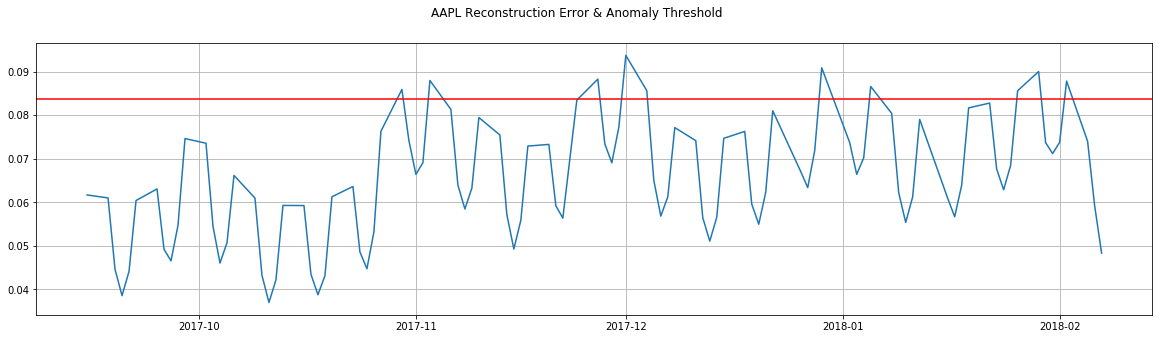

In [260]:
# investigate what is being flagged as anomalous 
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(df_stock['date'], df_stock['recon_error'])
plt.suptitle(le.classes_[stock_symbol_identifier] + " Reconstruction Error & Anomaly Threshold")
plt.axhline(y=anomaly_threshold, color='r', linestyle='-')
ax.grid(True)


,close,close_avg_10,close_avg_3,close_avg_5,date,day,day_of_month,high,low,open,open_close,raw_close,raw_open_close,raw_volume,symbol,volume,recon_error
5031,0.446949,0.475370,0.450093,0.460118,2018-02-01,0.75,0.000000,0.442865,0.450746,0.440711,0.415130,167.78,0.615,47230787,AAPL,0.075939,0.073773
5032,0.425664,0.469903,0.443717,0.453492,2018-02-02,1.00,0.033333,0.437607,0.431002,0.437341,0.238905,160.50,-5.500,86593825,AAPL,0.139641,0.087840
5033,0.413940,0.463660,0.432937,0.446590,2018-02-05,0.00,0.133333,0.429170,0.418848,0.417380,0.322190,156.49,-2.610,72738522,AAPL,0.117219,0.074009
5034,0.433061,0.459395,0.428256,0.444218,2018-02-06,0.25,0.166667,0.428708,0.412919,0.405028,0.633718,163.03,8.200,68243838,AAPL,0.109945,0.059302
5035,0.422858,0.454927,0.427310,0.439470,2018-02-07,0.50,0.200000,0.427783,0.427944,0.428908,0.295245,159.54,-3.545,51608580,AAPL,0.083024,0.048328


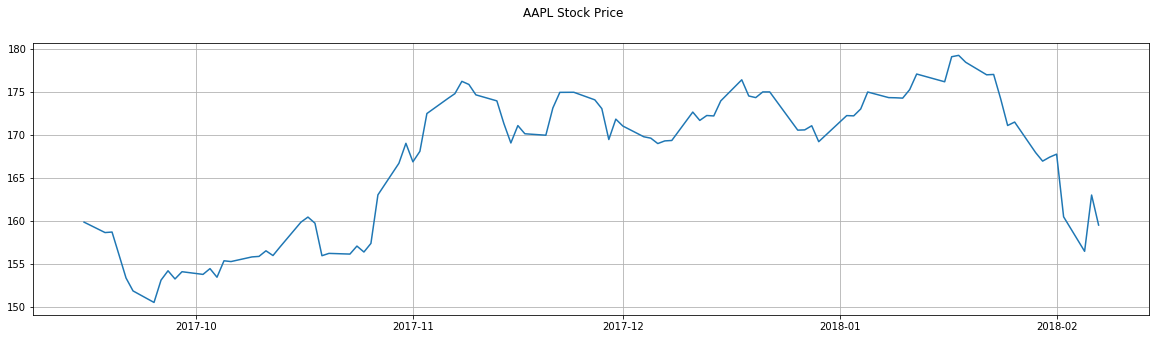

In [261]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(df_stock['date'], df_stock['raw_close'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Price")
df_stock.tail()

Let's flag some of the latest anomalies and see if we can tie them to news events.

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-29 00:00:00'), Timestamp('2018-02-02 00:00:00')]


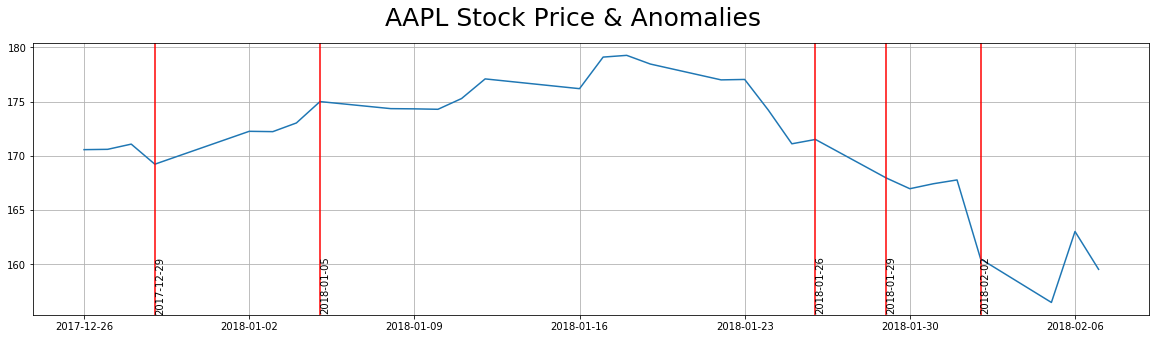

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-29 00:00:00'), Timestamp('2018-02-02 00:00:00')]


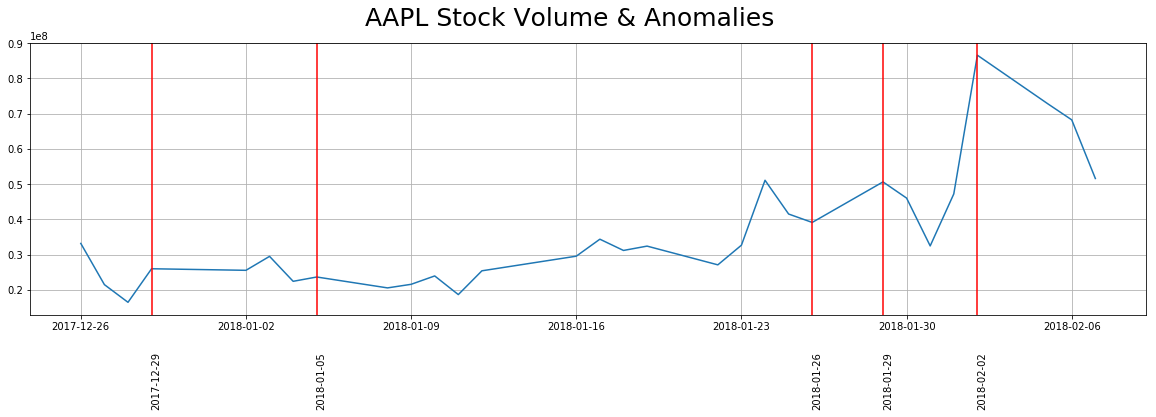

[Timestamp('2017-12-29 00:00:00'), Timestamp('2018-01-05 00:00:00'), Timestamp('2018-01-26 00:00:00'), Timestamp('2018-01-29 00:00:00'), Timestamp('2018-02-02 00:00:00')]


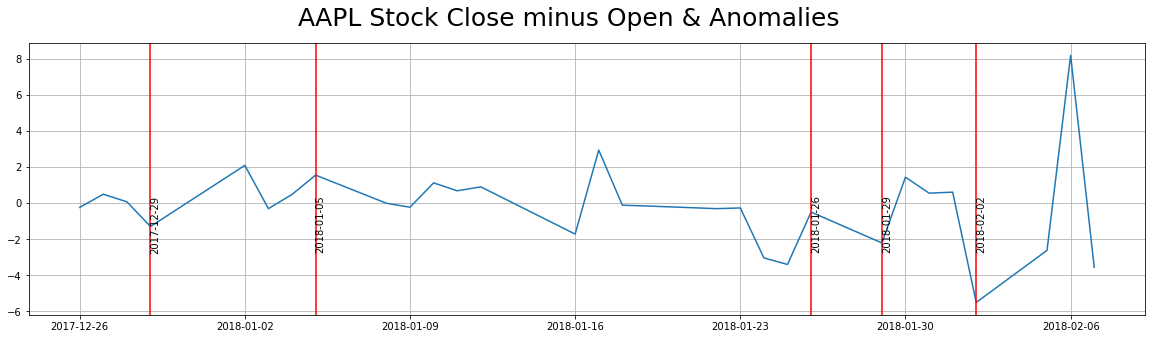

In [263]:
# print time series and highligh anomalies
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
df_stock_tmp = df_stock.tail(30)
ax.plot(df_stock_tmp['date'], df_stock_tmp['raw_close'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Price & Anomalies", fontsize=25)

xcoords = [d for e,d in zip(df_stock_tmp['recon_error'], df_stock_tmp['date']) if e > anomaly_threshold]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    plt.text(xc, 160, str(xc)[:10], rotation=90)
print(xcoords)
plt.show()


# print time series and highligh anomalies
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
df_stock_tmp = df_stock.tail(30)
ax.plot(df_stock_tmp['date'], df_stock_tmp['raw_volume'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Volume & Anomalies", fontsize=25)

xcoords = [d for e,d in zip(df_stock_tmp['recon_error'], df_stock_tmp['date']) if e > anomaly_threshold]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    plt.text(xc, 200000, str(xc)[:10], rotation=90)
print(xcoords)
plt.show()


# print time series and highligh anomalies
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
df_stock_tmp = df_stock.tail(30)
ax.plot(df_stock_tmp['date'], df_stock_tmp['raw_open_close'])
ax.grid(True)
plt.suptitle(le.classes_[stock_symbol_identifier] + " Stock Close minus Open & Anomalies", fontsize=25)

xcoords = [d for e,d in zip(df_stock_tmp['recon_error'], df_stock_tmp['date']) if e > anomaly_threshold]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    plt.text(xc, 0, str(xc)[:10], rotation=90)
print(xcoords)
plt.show()


 



**AAPL**

<B>2018-02-02</B><BR>
"Dow plunges 666 points -- worst day since Brexit"<BR>
https://money.cnn.com/2018/02/02/investing/stock-market-today-dow/index.html

<B>2018-01-29</B><BR>
"Why Did Apple (AAPL) Stock Dip Today?"<BR>
https://www.zacks.com/stock/news/290451/why-did-apple-aapl-stock-dip-today

<B>2018-01-05</B><BR>
"Apple ( AAPL ) rose Friday after the tech giant today said it will soon be providing Mac and iOS users with a patch addressing the Meltdown and Spectre security issues."<BR>
https://www.nasdaq.com/article/technology-sector-update-for-01052018-googgooglgprocnitcscoaapl-cm901199

<B>2017-12-29</B><BR>
Apple Apologizes for Slowing iPhones<BR>
https://money.usnews.com/investing/stock-market-news/articles/2017-12-29/apple-inc-aapl

